## Importing required libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Loading dataset for the model

In [ ]:
# Define data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    validation_split=0.3  # Reserve 30% for validation
)

# Load the dataset
data_dir = "face_age"  # Path to your dataset
img_size = (256, 256)  # Target image size
batch_size = 32 # Preferred batch size

# Create the training generator (70% of the data)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',  # Use 'sparse' for integer labels
    subset='training',  # Use 70% of the data for training
    seed=0 # Define a seed to get same data randomness everytime
)

# Create the validation generator (30% of the data)
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',  # Use 30% of the data for validation
    seed=0
)

# Function to map age labels to age range classes
def map_age_to_class(age):
    if 0 <= age <= 25:
        return 0  # Class 0: 0-25
    elif 26 <= age <= 50:
        return 1  # Class 1: 26-50
    elif 51 <= age <= 75:
        return 2  # Class 2: 51-75
    elif 76 <= age <= 100:
        return 3  # Class 3: 76-100
    else:
        raise ValueError(f"Age {age} is out of range (0-100).")

# Custom generator to modify labels
def modify_labels(generator):
    while True:  # Infinite loop to keep yielding batches
        images, labels = next(generator)
        # Map each label to its corresponding age range class
        modified_labels = np.array([map_age_to_class(int(label)) for label in labels])
        yield images, modified_labels

# Apply the label modification to the generators
train_generator_modified = modify_labels(train_generator)
val_generator_modified = modify_labels(val_generator)

Found 6891 images belonging to 98 classes.
Found 2886 images belonging to 98 classes.


## Processing images in the dataset

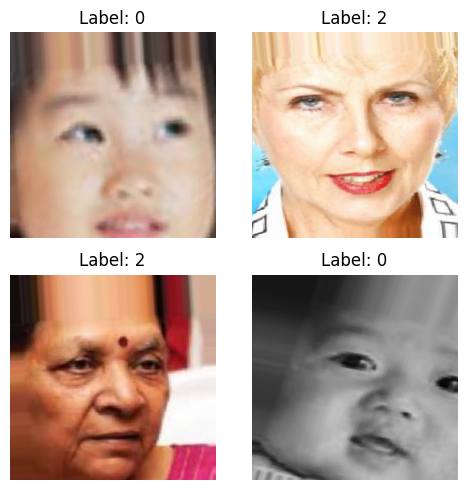

In [63]:
# Get a batch of images and labels from the training generator
images, labels = next(train_generator_modified)

# Plot 4 images
plt.figure(figsize=(5, 5))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i])  # Display the image
    plt.title(f"Label: {int(labels[i])}")  # Show the corresponding label
    plt.axis("off")  # Hide axes

plt.tight_layout()
plt.show()

## Building the model

First model is a simple CNN model consisting of 1 input layer of 128 neurons, after that 2 set of Conv2D+MaxPooling2D layers and at last a flatten and an output layer utilizing the softmax activation

In [ ]:
# Define early stopping in case if model performance stops to increase the training process can be halted early
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
# Creating a sequential CNN model
model = models.Sequential([
    layers.Conv2D(128, (4, 4), activation='relu', input_shape=(256, 256, 3)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((4, 4)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4, activation='softmax')  # 4 output classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator_modified,
    steps_per_epoch=len(train_generator),  # Number of batches per epoch
    epochs=10,
    validation_data=val_generator_modified,
    validation_steps=len(val_generator),  # Number of validation batches
    callbacks=[early_stopping] # Implementing early stopping
)
# Saving the model to decrease repeated computation time
model.save('test_model.keras')

c:\CODE\Personal\Face Age Detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 999s 5s/step - accuracy: 0.5385 - loss: 1.1516 - val_accuracy: 0.5360 - val_loss: 1.0705
Epoch 2/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1063s 5s/step - accuracy: 0.5394 - loss: 1.0753 - val_accuracy: 0.5541 - val_loss: 1.0418
Epoch 3/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1010s 5s/step - accuracy: 0.5487 - loss: 1.0600 - val_accuracy: 0.5641 - val_loss: 1.0395
Epoch 4/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 925s 4s/step - accuracy: 0.5560 - loss: 1.0465 - val_accuracy: 0.5755 - val_loss: 1.0176
Epoch 5/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 885s 4s/step - accuracy: 0.5769 - loss: 1.0136 - val_accuracy: 0.5703 - val_loss: 1.0449
Epoch 6/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 885s 4s/step - accuracy: 0.5715 - loss: 1.0090 - val_accuracy: 0.5617 - val_loss: 0.9987
Epoch 7/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 882s 4s/step - accuracy: 0.5700 - loss: 1.0112 - val_accuracy: 0.6008 - val_loss: 0.9641
Epoch 8/10
216/216 ━━━━━━━━━━━━━━━━━━━━ 1030s 5s/step - accuracy: 0.5909 - loss: 0.9745 - val_a

## Testing the model

In [ ]:
# Function to return corresponding class to the predicted label
def pred_class(prediction):
    if prediction==0:
        return "Age 0-25"
    elif prediction==1:
        return "Age 26-50"
    elif prediction==2:
        return "Age 51-75"
    elif prediction==3:
        return "Age 76-100"
    else:
        return "Invalid Output"


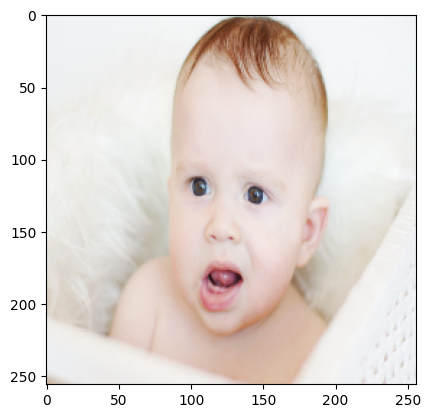

In [ ]:
# Reading an image for testing
img = cv2.imread('Test\my-babys-face-is-asymmetrical.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img_rgb, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
# Creating a prediction from the model
pred = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


In [47]:
print(pred_class(np.argmax(pred)))

Age 0-25


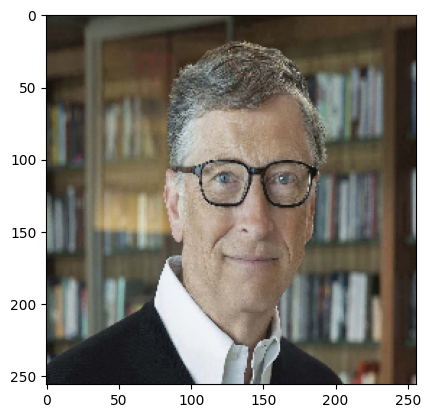

In [48]:
img = cv2.imread('Test\GA311881_Bill_Gates.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img_rgb, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [49]:
pred = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


In [50]:
print(pred_class(np.argmax(pred)))

Age 76-100


## Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

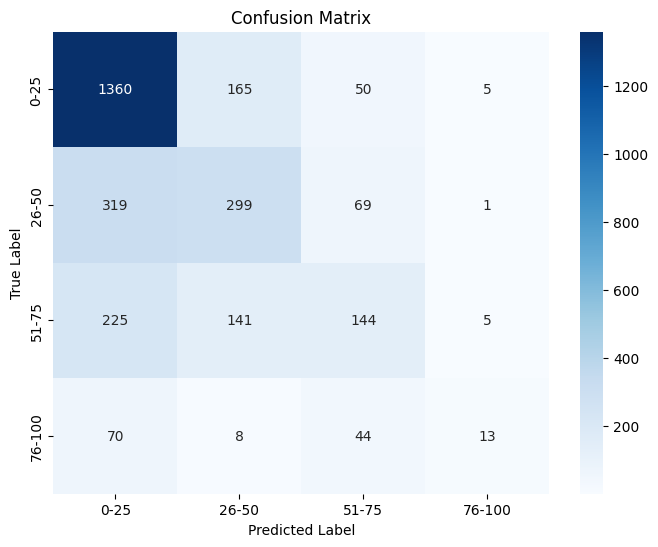

In [64]:
# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation generator to get true and predicted labels
for images, labels in val_generator_modified:
    # Predict the labels for the batch
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)  # Convert logits to class indices
    
    # Append true and predicted labels
    true_labels.extend(labels)
    predicted_labels.extend(predicted_classes)
    
    # Stop after iterating through the entire validation dataset
    if len(true_labels) >= len(val_generator) * batch_size:
        break

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names (replace with your actual class names)
class_names = ["0-25", "26-50", "51-75", "76-100"]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()